# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

## Load raw split frame

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr

In [4]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq
import pyarrow
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

## SCIP computed features

In [5]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

## Load processed frame

In [6]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201141724/features.parquet").to_pandas()

In [6]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201141724/").glob("*.parquet")
], axis=0)

In [7]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem[:-8])

In [11]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/home/maximl/scratch/data/hpc/datasets/wbc/meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [10]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

In [ ]:
%%time
df["meta_label"] = "unknown"
chunk_size = len(df)//10 + 1
for i in range(0, 10):
    df.iloc[i*chunk_size:(i+1)*chunk_size, df.columns.get_loc("meta_label")] = df.iloc[i*chunk_size:(i+1)*chunk_size].apply(map_to_class, axis=1)
    print(i)

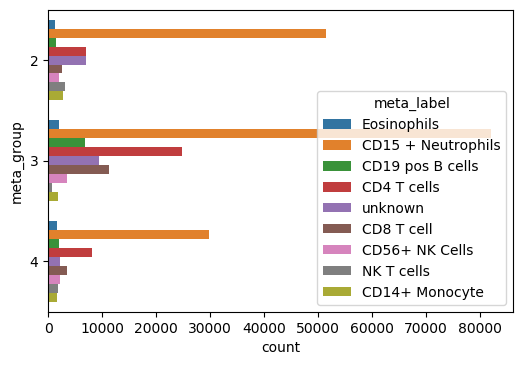

In [11]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [12]:
df["meta_label"].value_counts()

CD15 + Neutrophils    163421
CD4 T cells            39840
unknown                18560
CD8 T cell             17282
CD19 pos B cells       10438
CD56+ NK Cells          7744
CD14+ Monocyte          6207
NK T cells              5775
Eosinophils             4783
Name: meta_label, dtype: int64

In [13]:
df.shape

(274050, 2519)

In [14]:
df = df.reset_index(drop=True)

In [15]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202201141724/features.parquet")